#Classification of Water Consumption Types

[Assignment SI - Infos](https://drive.google.com/file/d/1lh5a0YxVsC-NXtsIpucTVCrfJR_8KZB4/view?usp=sharing)

[Dataset Train](https://virtual.ipb.pt/access/content/group/5b961040-5442-11ee-bfc7-421e367e2b5a/Assignment/train.csv)

[Dataset Competition](https://virtual.ipb.pt/access/content/group/5b961040-5442-11ee-bfc7-421e367e2b5a/Assignment/competition.csv)

### 1) **IMPORT** and **UTILITY**

Import all usefull libraries and define some usefull functions

In [1]:
###########################
# data libraries
###########################
import pandas as pd
import numpy as np

###########################
# plot libraries
###########################
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

from sklearn.preprocessing import OrdinalEncoder, StandardScaler


### 2) **READ DATA FILES**

Read data file uploaded to this google colab

In [2]:
###########################
# import csv in dataframe
###########################

train = pd.read_csv("train_without_outliers.csv")
test = pd.read_csv("competition.csv")

train.Consumer_type.unique()

array(['domestic', 'industrial', 'rural commercial',
       'low income families', 'construction', 'rural domestic',
       'rural expansion'], dtype=object)

### 3) **PREPROCESSING**

3.1) DATA VISUALIZATION

     try to visualize data and some correlation/outliers or any possible issues

<Axes: xlabel='Consumer_type', ylabel='Count'>

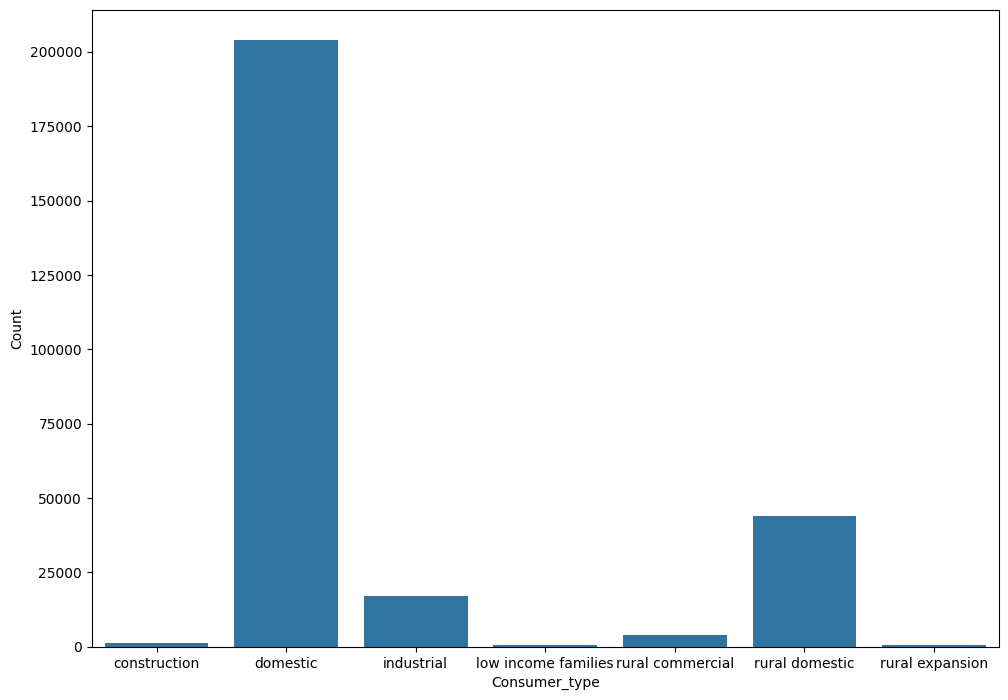

In [3]:
###########################
# try to solve unbalance class
# problem
###########################
unb = pd.DataFrame({'Count' : train.groupby( ["Consumer_type"] ).size()}).reset_index()
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
sns.barplot(data=unb, x=unb["Consumer_type"], y=unb["Count"])

###########################
# problem: we have too many 
# domestic class
###########################

In [ ]:
tresh_def = train[train['Consumer_type'] == 'domestic']['Consumption']
tresh_def_zero = tresh_def[tresh_def.values == 0]
tresh_def_zero.count()

#### 38516 are 0 values of water consumption

tresh_def = tresh_def[tresh_def.values < 10]
tresh_def.count()

#### let's define a treshold --> try with 10

In [ ]:
pp_train = train[train['Consumption'] >= 0]

#### see after the treshold definition

unb = pp_train.groupby('Consumer_type')['Consumer_type'].count()
sns.barplot(data=unb, x=unb.Consumer_type, y=unb[0])

3.2) RANDOM FOREST

     create a rf model

In [28]:
###########################
# transform classes into numbers
###########################
def categoricalToNumerical(df, cols):
  enc = OrdinalEncoder(dtype=np.int16)
  df[cols]= enc.fit_transform(df[cols])

In [29]:
###########################
# preparing dataset, transform classes into numbers
# and separate test and its target
###########################

categoricalToNumerical(train, ['Consumer_type', 'Consumer_number', 'Installation_zone'])

train_target = train['Consumer_type']
train.drop(columns=['Consumer_type'],inplace=True)

train.head()


,Year,Month,Consumption,Consumer_number,Installation_zone
0,2013,1,0,7352,0
1,2013,1,6,12578,11
2,2013,1,1,9603,11
3,2013,1,13,4674,11
4,2013,1,5,423,11


In [30]:
### Import and Function
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)

rfc = RandomForestClassifier(
    ccp_alpha=0.01,
    n_jobs=-1,
    n_estimators=20,
    max_depth=10,
    random_state=42,
    oob_score=True,
    max_features=None,
    bootstrap=True,
)

# Create the parameter grids
parameter_grid = {
    #"n_estimators": [10, 25, 50],
    #"max_depth": [10, 30, None],
    # "max_features": ["sqrt", "log2", None],
    #"criterion": ["gini", "entropy", "log_loss"]
    # "oob_score": [True, False]
    #'random_state': [0, 10],
    #'min_samples_leaf':[1, 4, 8],
    #'min_samples_split': [2, 6, 10],
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=2)
cross_validation.get_n_splits(train, train_target)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=3,
    scoring=SCORING,
    return_train_score=True,
    refit="balanced_accuracy",
)

grid_search.fit(train, train_target)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\marco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/2] END  accuracy: (train=0.913, test=0.913) balanced_accuracy: (train=0.286, test=0.286) f1: (train=0.275, test=0.276) total time=   3.7s


c:\Users\marco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/2] END  accuracy: (train=0.913, test=0.913) balanced_accuracy: (train=0.286, test=0.286) f1: (train=0.276, test=0.275) total time=   3.3s


c:\Users\marco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(ccp_alpha=0.01, max_depth=10,
                                              max_features=None,
                                              n_estimators=20, n_jobs=-1,
                                              oob_score=True, random_state=42),
             param_grid={}, refit='balanced_accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=3)

In [31]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_dtc = grid_search.best_estimator_
best_dtc

Best score: 0.2855806218581516
Best parameters: {}


RandomForestClassifier(ccp_alpha=0.01, max_depth=10, max_features=None,
                       n_estimators=20, n_jobs=-1, oob_score=True,
                       random_state=42)

In [ ]:
my_model = best_dtc
my_model.fit(train, train_target)
my_model.score(train, train_target)